In [ ]:
# !pip install tensorflow==2.5.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.5.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.5.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


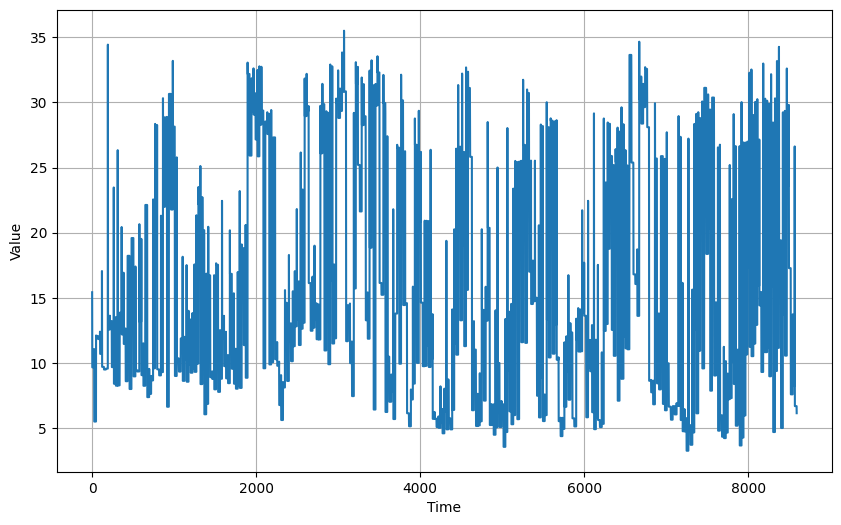

In [5]:
df = pd.read_parquet('/content/drive/MyDrive/12 Month Historical WESM.parquet')

df = df.reset_index()

df['SYSTEM'] = df['SYSTEM'] / 1000

time = np.array(df.index)
series = np.array(df['SYSTEM'])

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500

time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)
Epoch 1/100
10/10 [==============================] - 10s 66ms/step - loss: 71.2613 - mae: 71.7594 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 85ms/step - loss: 66.8958 - mae: 67.3947 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 102ms/step - loss: 60.3546 - mae: 60.8530 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 88ms/step - loss: 52.7585 - mae: 53.2557 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 80ms/step - loss: 44.5729 - mae: 45.0705 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 100ms/step - loss: 35.7989 - mae: 36.2972 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 2s 102ms/step - loss: 26.3309 - mae: 26.8279 - lr: 1.9953e-08
Epoch 8/100
10/10 [==========

(5.655877526068172e-09,
 0.0015757960743081156,
 -9.02141965031624,
 218.24625778794288)

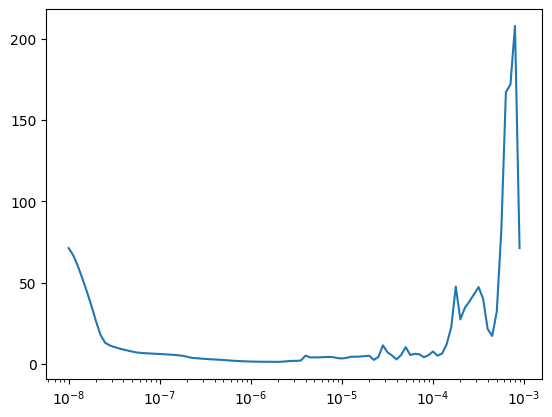

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 60])
plt.axis()

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)# YOUR CODE HERE)

# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 6s 22ms/step - loss: 10.7224 - mae: 11.2105
Epoch 2/150
25/25 [==============================] - 1s 22ms/step - loss: 3.0731 - mae: 3.5413
Epoch 3/150
25/25 [==============================] - 1s 23ms/step - loss: 2.5002 - mae: 2.9722
Epoch 4/150
25/25 [==============================] - 1s 22ms/step - loss: 2.1714 - mae: 2.6348
Epoch 5/150
25/25 [==============================] - 1s 20ms/step - loss: 1.4353 - mae: 1.8383
Epoch 6/150
25/25 [==============================] - 1s 24ms/step - loss: 1.2801 - mae: 1.6462
Epoch 7/150
25/25 [==============================] - 1s 24ms/step - loss: 1.1837 - mae: 1.5506
Epoch 8/150
25/25 [==============================] - 1s 23ms/step - loss: 1.1425 - mae: 1.4964
Epoch 9/150
25/25 [==============================] - 1s 23ms/step - loss: 1.0847 - mae: 1.4243
Epoch 10/150
25/25 [==============================] - 1s 22ms/step - loss: 1.2004 - mae: 1.6246
Epoch 11/150
25/25 [===========================

267/267 [==============================] - 5s 11ms/step


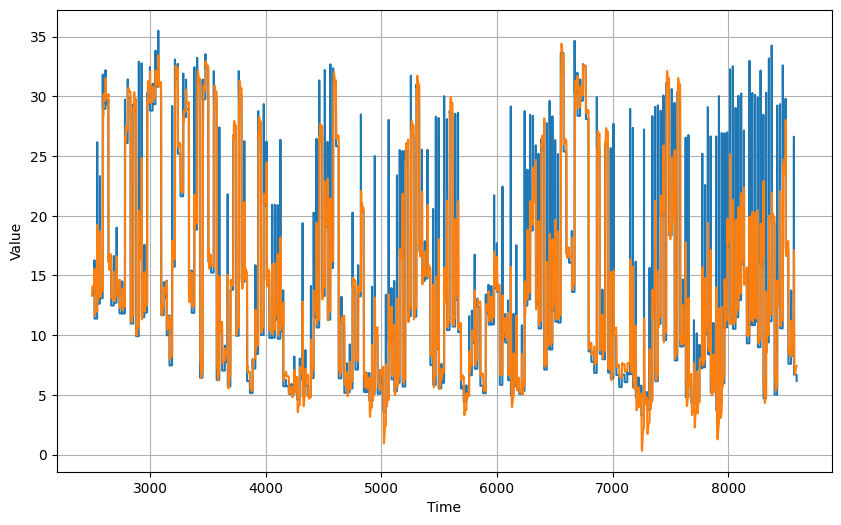

In [12]:
cnn_rnn__dnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_rnn__dnn_forecast = cnn_rnn__dnn_forecast[split_time - window_size:-1, -1, 0]


plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_rnn__dnn_forecast)

267/267 [==============================] - 2s 8ms/step


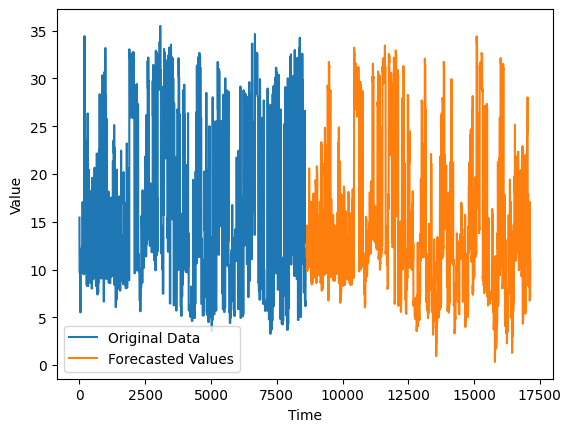

In [13]:
# Example of forecasting 10 steps forward
num_steps_forward = 10

# Loop to generate forecasts for future time steps
for _ in range(num_steps_forward):
    # Generate forecast for the next time step
    cnn_rnn__dnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

    # Extract the forecast for the next time step
    next_forecast = cnn_rnn__dnn_forecast[-1, -1, 0]

    # Update input data with the new forecast
    series = np.append(series, next_forecast)

# Plot original data
plt.plot(series, label='Original Data')

# Plot forecasted values (selecting the last forecasted value for each time step)
forecasted_values = cnn_rnn__dnn_forecast[:, -1, 0]  # Selecting the last forecasted value for each time step
plt.plot(range(len(series), len(series) + len(forecasted_values)), forecasted_values, label='Forecasted Values')

# Set labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.show()
